# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 4: Multiple Linear Regression

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Bootstrap Resampling</li>
<li> Multiple Linear Regression Basics</li>
<li> Predictors, predictors, predictors </li>
<li> Overfitting </li>    

## Learning Goals

This Jupyter notebook accompanies Lecture 4. By the end of this lecture, you should be able to:

- Know the basic approach to implementing resampling methods (bootstrapping and randomization testing) in python.
- Create *design matrices* to use for specific models to be fit.
- Be comfortable fitting, interpreting and using multiple regression models from both `sklearn` and `statsmodels`.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels as sm
import statsmodels.regression.linear_model as lm
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Part 0: Reading the data and re-fitting Lec3 models

We will be using the same data as last time (both the train and test splits): modeling `votergap` from the 2016 election (Trump-Clinton) from `density` (population density in persons per square mile) and other predictors where each row represents a county in the US. 

We start by reading in the datasets for you and refitting the simple regression models from last time:

**Important note: use the training dataset for all exploratory analysis and model fitting.  Only use the test dataset to evaluate and compare models.**


In [3]:

train = pd.read_csv("../data/county_election_train.csv")
test = pd.read_csv("../data/county_election_test.csv")

#recall we log-transformed population density to make linear regression more appropriate
train['log_density'] = np.float64(np.log(train['density']))
test['log_density'] = np.float64(np.log(test['density']))

# and we fit the simple regression model for y = votergap and x = log_density in both sklearn and statmodels

# sklearn: note the better way to define a single predictor design matrix
regress1 = LinearRegression(fit_intercept=True).fit(train[['log_density']], train['votergap'])
print("Beta0 =", regress1.intercept_ ,", Beta1 =", regress1.coef_)

# statsmodels approach: remember to manually add the intercept.
X = sm.tools.add_constant(train['log_density'])
model1 = lm.OLS(train['votergap'],X).fit()
print("Statmodels results: \n",model1.params,sep="")

model1.summary()

Beta0 = 50.77985735371276 , Beta1 = [-4.96440868]
Statmodels results: 
const          50.779857
log_density    -4.964409
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     218.7
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           1.40e-47
Time:                        22:06:51   Log-Likelihood:                -12600.
No. Observations:                2620   AIC:                         2.520e+04
Df Residuals:                    2618   BIC:                         2.522e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          50.7799      1.405     36.152      0.000      48.026      53.534
log_density    -4.9644      0.336    -14.787      0.000      -5.623      -4.306
==============================================================================
Omnibus:                      288.397   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.549
Skew:                          -0.895   Prob(JB):                     2.57e-85
Kurtosis:                       3.603   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

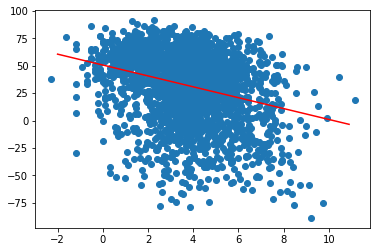

In [4]:
# Plot the line on the scatterplot

x_dummy = np.arange(-2,11,0.1)
yhat_dummy_regress = regress1.predict(x_dummy.reshape(-1, 1))

plt.scatter(train['log_density'],train['votergap'])
plt.plot(x_dummy,yhat_dummy_regress,c="r",label="Linear Regression")

plt.show()

In [5]:
# And finally, evaluate on the test set (useful going forward):

yhat1_train = regress1.predict(train[['log_density']])
yhat1_test = regress1.predict(test[['log_density']])

r2_train = sk.metrics.r2_score(train['votergap'], yhat1_train)
r2_test = sk.metrics.r2_score(test['votergap'], yhat1_test)

mse_train = sk.metrics.mean_squared_error(train['votergap'], yhat1_train)
mse_test = sk.metrics.mean_squared_error(test['votergap'], yhat1_test)
      
results1 = pd.DataFrame(index = ["train","test"])    
results1['R-squared'] = [r2_train,r2_test]
results1['MSE'] = [mse_train,mse_test]

results1

,R-squared,MSE
train,0.077084,880.297056
test,0.060620,887.858898


**Q0.1** Calculate the residuals for the train set from the linear regression model.  Plot the histogram of residuals and residuals-vs.-predicted scatterplot.  Comment on the assumptions of the linear regression model.

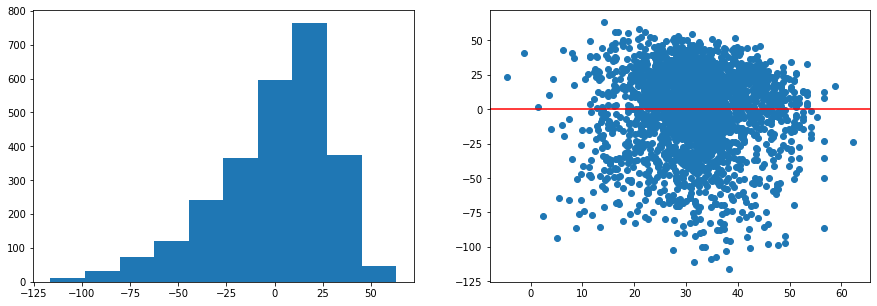

In [6]:
######
# your code here
######


residuals = train['votergap'] - yhat1_train

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(residuals)
ax[1].scatter(yhat1_train, residuals)
ax[1].axhline(y=0, c="red")

plt.show()


The residual histogram and scatterplot below illustrate that the assumptions are reasonable (even though the residuals are moderately left-skewed, there are not any extreme outliers).  The residual scatterplot does not show any clear non-linearities (curvature) or non-constant variance (sometimes called heteroscedasticity).

## Part 1: Bootstrap in Linear Regression 

The residual histogram is clearly non-normal, and this may affect teh reliability of probabilistic based inference ($t$-distribution based ones).  The bootstrap approach is an alternative method to build confidence intervals when this assumption is violated.

**Q1.1** Perform a bootstrap approach to calculate the 95\% confidence intervals based on the method, and compare them to the probabilistic-based ones above from statsmodels.

In [7]:
######
# your code here
######

# define some parameters and initializations:
nboots = 1000
n = np.size(train['votergap'])
np.random.seed(109)
beta1_boots = []

# use a for loop to do the reampling for us
for boot in np.arange(nboots):
    indices = np.random.choice(n,size=n,replace=True)
    ######
    # your code here
    ######
    y_boot = train['votergap'].iloc[indices]
    x_boot = train['log_density'].iloc[indices].values.reshape(-1, 1)
    regress_boot = LinearRegression(fit_intercept=True).fit(x_boot, y_boot)
    beta1_boot = regress_boot.coef_[0]
    beta1_boots.append(beta1_boot)

The empirical bootstrap 95% confidence interval for the slope is: [-5.71426054 -4.2886359 ]


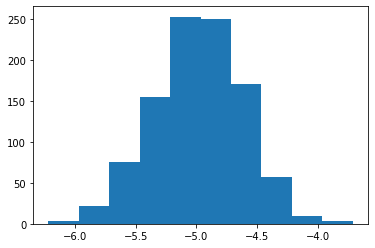

In [8]:

    
# plot the histogramand pull of the quantiles from the results array using np.quantile and 


######
# your code here
######
    
print("The empirical bootstrap 95% confidence interval for the slope is:",np.quantile(beta1_boots,[0.025,0.975]))

plt.hist(beta1_boots)
plt.show()

*your answer here*

**Solutions:**

The bootstrap confidence interval is (-5.714, -4.289) while the standard $t$-based confidence interval is (-5.62, -4.31): they are very similar to each other (centered in a similar place, the bootstrap interval is slightly wider) and the difference in widths is likely due to the outliers in the upper right of the original scatterplot adding extra variabilitiy into the bootstrap approach (sometimes they are not included in the bootstrap resample while sometimes they are included multiple times).

Alternatively, hypothesis testing can be performed with a similar resampling approach (call the permutation or randomization test).  As all hypothesis tests, the sampling distribution (of the statistic of interest: here it is $\beta_1$) should be determined assuming the null hypothesis to be true (to fix the Type 1 error rate at $\alpha = 0.05$).  

Thus, rather than bootstrap resampling the obseervations from the data set, the association is removed empirically: by reshuffling the response variable across the measurements in the predictor variable(s).  One iteration is shown below:

In [9]:
n = np.size(train['votergap'])
y_perm = np.random.choice(train['votergap'],size=n,replace=False)
regress_perm = LinearRegression(fit_intercept=True).fit(train[['log_density']], y_perm)

print("Observed Beta1 =", regress1.coef_, ", Permuted Beta1 =", regress_perm.coef_)


Observed Beta1 = [-4.96440868] , Permuted Beta1 = [0.03829341]


Here we see that our permutaed $\hat{\beta}_1$ is much colser to the null value of zero (in magnitude) than the actual observed one.  Thus our empirically estimated p-value is 0 (our repermuted slope was more extreme than what was actually observed 0 times out of 1 permutation iterations).

**Q1.2** Perform a permutation test (with 1000 iterations) to test whether the linear relationship between `votergap` and `log_density` is statistically significant.

Empirical estimate of the p-value based on 1000 iterations is: 0.0


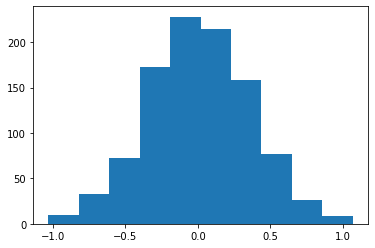

In [10]:
######
# your code here
######

nperms = 1000
n = np.size(train['votergap'])
np.random.seed(109)
beta1_perms = []

# use a for loop to do the reampling for us
for boot in np.arange(nboots):
    ######
    # your code here
    ######
    y_perm = np.random.choice(train['votergap'],size=n,replace=False)
    regress_perm = LinearRegression(fit_intercept=True).fit(train[['log_density']], y_perm)

    beta1_perms.append(regress_perm.coef_[0])

plt.hist(beta1_perms)
print("Empirical estimate of the p-value based on 1000 iterations is:" , 
      np.mean(np.abs(beta1_perms)>np.abs(regress1.coef_[0])))

The sampling distribution based on this permutation test (derived assuming the null hypothesis) is no where near the actual observed slope of -4.96.  So no permutation estimates were larger in magnitude than the actual observed estimate, the empirical p-value is calculated to be 0/1000; essentially zero.  There is plenty of evidence to reject the null hypothesis and conclude that voter gap is linearly related to log-density (in fact, negatively related).

## Part 2: Multiple Regression

There are many more predictors in the data set (see below), which are mostly percentage of residents in the county (income is median income in dollars, and cancer is number of cancer cases per 100,000 residents per year).

In [11]:
print(train.columns)
train.describe()

Index(['state', 'fipscode', 'county', 'population', 'hispanic', 'minority', 'female', 'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'density', 'cancer', 'trump', 'clinton', 'votergap', 'log_density'], dtype='object')


,fipscode,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,trump,clinton,votergap,log_density
count,2620.000000,2.620000e+03,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2580.000000,2620.000000,2620.000000,2620.000000,2620.000000
mean,30697.507634,9.822633e+04,9.247841,14.610524,49.940028,5.486756,47137.843511,14.997672,20.105496,25.954962,30.991832,265.478931,228.681589,63.568398,31.706439,31.861962,3.810705
std,14945.089720,3.284333e+05,13.806757,15.823972,2.211987,1.946932,12007.432050,6.785728,8.981552,5.201513,4.496507,1767.597996,55.337794,15.638465,15.384481,30.889891,1.727548
min,1001.000000,4.500000e+01,0.205000,0.855000,28.479000,1.800000,21658.000000,1.300000,2.600000,8.700000,11.800000,0.100000,47.100000,4.122000,3.145000,-88.725000,-2.302585
25%,19044.500000,1.121975e+04,2.100000,4.116750,49.480500,4.100000,39152.250000,9.900000,13.900000,22.600000,28.400000,17.700000,193.750000,55.002500,20.458000,15.022000,2.873565
50%,29204.000000,2.570450e+04,4.009500,7.950000,50.364000,5.300000,45227.500000,13.550000,17.800000,25.800000,31.200000,46.250000,230.200000,66.699000,28.414000,38.264500,3.834061
75%,46005.500000,6.532075e+04,9.503000,19.238750,51.039250,6.500000,52602.250000,19.200000,23.725000,29.400000,33.800000,113.325000,265.100000,75.098500,40.011500,54.699000,4.730260
max,56045.000000,9.848011e+06,95.824000,93.411000,56.739000,24.000000,125635.000000,53.300000,75.100000,41.400000,47.600000,69468.400000,445.400000,95.273000,92.847000,91.636000,11.148627


In [12]:
variables = ['state', 'fipscode', 'county', 'population', 'hispanic', 'minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'density', 
             'cancer', 'trump', 'clinton', 'votergap', 'log_density']


**Q2.1** Fit a simple regression model to predict `votergap` from `log_minority`.  Interpret the slope coefficient and its confidence interval.

In [13]:
######
# your code here
######
train['log_minority'] = np.float64(np.log(train['minority']))
test['log_minority'] = np.float64(np.log(test['minority']))


regress2_1 = LinearRegression(fit_intercept=True).fit(train[['log_minority']], train['votergap'])
print("Beta0 =", regress2_1.intercept_ ,", Beta1 =", regress2_1.coef_)

# statsmodels approach: remember to manually add the intercept.
X = sm.tools.add_constant(train['log_minority'])
model2 = lm.OLS(train['votergap'],X).fit()
model2.summary()

Beta0 = 68.30514486176875 , Beta1 = [-16.60661979]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     995.5
Date:                Wed, 01 Jul 2020   Prob (F-statistic):          1.83e-185
Time:                        22:06:54   Log-Likelihood:                -12283.
No. Observations:                2620   AIC:                         2.457e+04
Df Residuals:                    2618   BIC:                         2.458e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           68.3051      1.264     54.033      0.000      65.826      70.784
log_minority   -16.6066      0.526    -31.552      0.000     -17.639     -15.575
==============================================================================
Omnibus:                      255.291   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.018
Skew:                          -0.779   Prob(JB):                     5.99e-77
Kurtosis:                       3.889   Cond. No.                         6.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slope is estimated to be -16.607 with a confidence interval of (-17.64, -15.58): a 1-unit change in log_minority (a 2.718-fold increase in the percentage of residents that are considered minorities) is associated with a 16.6 point decrease in the voter gap.  Counties with more minorities voted less in favor of Trump.

**Q2.2** Fit a multiple regression model to predict `votergap` from `log_minority` and `log_density`.  Interpret the slope coefficients.

In [14]:
######
# your code here
###### 

regress2_2 = LinearRegression(fit_intercept=True).fit(train[['log_minority','log_density']], train['votergap'])
print("Beta0 =", regress2_2.intercept_ ,", Beta's =", regress2_2.coef_)


Beta0 = 78.79858717243378 , Beta's = [-15.52533573  -3.37636167]


The slope for `log_minority` is now estimated to be -15.53 : a 1-unit change in log_minority (a 2.718-fold increase in the percentage of residents that are considered minorities) is associated with a 15.5 point decrease in the voter gap if population density is held constant.  The slope for `log_density` is now estimated to be -3.376 : a 1-unit change in log_density (a 2.718-fold increase in population density) is associated with a 3.4 point decrease in the voter gap if percentage of resident that are minorities is held constant.

**Q2.3** Compare the coefficient estimate for `log_density` in both the simple regression model and the multiple regression model.  Why are the different/similar?

The coefficient was estimated to be -4.96 in the simple regression is now about 1/3 less: -3.37.  This decrease is due to the fact that we are now controlling for the effect of log_minority, and density and minority percentage are positively correlated.  The estimate -4.96 was partially due to the 'effect' of minority as a predictor.

## Part 3: Predictors, predictors, predictors

In this part we will explore 3 very useful types of predictors commonly used in multiple regression (and modeling in general).

1. Categorical Predictors (and dummy variables)
2. Interaction Effects
3. Polynomial Terms as one approach to model non-linearities

**Q3.1** Create two sets of dummy variables: 
1. A variable called `high_density` to indicate whether a county is above the median population density of all counties in the training set.

2. For the 50 different states (+DC) in the `state` variable

Note: pandas's [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) will be useful for the second task.  Note: it would be useful to use the argument `drop_first=True`

In [15]:
######
# your code here
######
train['high_density'] = 1*(train['density'] > np.median(train['density']))


state_dummies = pd.get_dummies(train['state'],drop_first=True)
train = pd.concat([train,state_dummies],axis=1)

print(state_dummies.shape)
train.head()

(2620, 49)


,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,trump,clinton,votergap,log_density,log_minority,high_density,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,1001,Autauga County,50756,2.842,22.733,51.475,5.2,54366,13.8,21.9,28.6,34.1,91.8,186.5,73.436,23.957,49.479,4.519612,3.123818,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alabama,1003,Baldwin County,179878,4.550,12.934,51.261,5.5,49626,11.0,28.6,22.3,27.4,114.6,229.4,77.351,19.565,57.786,4.741448,2.559860,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alabama,1007,Bibb County,21587,2.409,23.930,46.110,6.6,39546,22.1,10.2,33.9,40.3,36.8,230.3,76.966,21.422,55.544,3.605498,3.175133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alabama,1009,Blount County,58345,8.954,4.229,50.592,5.4,45567,21.9,12.3,28.0,34.6,88.9,205.3,89.852,8.470,81.382,4.487512,1.441966,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alabama,1011,Bullock County,10985,7.526,72.831,45.241,7.8,26580,34.5,14.1,31.7,43.0,17.5,211.2,24.229,75.090,-50.862,2.862201,4.288142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Q3.2** Fit a linear regression model to predict `votergap` from `high_density`.  Interpret the model coefficient estimates.  When would a model like this be preferred to using the quantitative version of `density` or `log_density`?

In [16]:
######
# your code here
######
regress3_2 = LinearRegression(fit_intercept=True).fit(train[['high_density']], train['votergap'])
print("Beta0 =", regress3_2.intercept_ ,", Beta1 =", regress3_2.coef_)

Beta0 = 36.848677862595416 , Beta1 = [-9.97343206]


Counties that are below the median population density voted in favor of Trump by 36.85 points, while states above the median population density voted in favor of Trump by 9.97 points less: still 36.85 - 9.97 = 26.9 in favor of Trump.  This type of model could be preferred if the scatterplot showed a drop-off around the median as using this type of predictor models a step-function with a change at the median of the predictor.

**Q3.3** Fit a linear regression model to predict `votergap` from `state` (or the state dummies, whichever is easier) in both sklearn and in statsmodels.  Interpret the slope coefficient associated with Massachusetts.  

In [17]:
######
# your code here
######
state_dummies = pd.get_dummies(train['state'],drop_first=True)
regress3_3 = LinearRegression(fit_intercept=True).fit(state_dummies, train['votergap'])
print("Beta0 =", regress3_3.intercept_ ,", Beta for Mass =", regress3_3.coef_[state_dummies.columns=='Massachusetts'][0])


# statsmodels approach: remember to manually add the intercept.
X = sm.tools.add_constant(state_dummies)
model2 = lm.OLS(train['votergap'],X).fit()
model2.summary()



Beta0 = 29.01118867924516 , Beta for Mass = -58.4644029649595


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     24.69
Date:                Wed, 01 Jul 2020   Prob (F-statistic):          1.35e-177
Time:                        22:06:54   Log-Likelihood:                -12199.
No. Observations:                2620   AIC:                         2.450e+04
Df Residuals:                    2570   BIC:                         2.479e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   29.0112      3.532      8.214      0.000      22.086      35.937
Arizona                -18.1326      7.520     -2.411      0.016     -32.878      -3.387
Arkansas                 4.0297      4.759      0.847      0.397      -5.301      13.361
California             -31.6688      5.244     -6.039      0.000     -41.952     -21.386
Colorado               -11.8396      4.995     -2.370      0.018     -21.634      -2.046
Connecticut            -37.5486     10.340     -3.631      0.000     -57.824     -17.273
Delaware               -41.3592     18.521     -2.233      0.026     -77.677      -5.042
District of Columbia  -117.7362     25.953     -4.536      0.000    -168.628     -66.844
Florida                 -1.6555      5.019     -0.330      0.742     -11.497       8.186
Georgia                  0.0395      4.190      0.009      0.992      -8.177       8.256
Hawaii                 -63.7102     13.332     -4.779      0.000     -89.853     -37.567
Idaho                   17.5554      5.508      3.187      0.001       6.754      28.357
Illinois                 3.6681      4.452      0.824      0.410      -5.062      12.398
Indiana                 11.3572      4.510      2.518      0.012       2.513      20.202
Iowa                     0.3843      4.554      0.084      0.933      -8.545       9.314
Kansas                  23.5401      4.434      5.309      0.000      14.846      32.235
Kentucky                20.7022      4.339      4.771      0.000      12.193      29.211
Louisiana               -1.0969      5.043     -0.217      0.828     -10.987       8.793
Maine                  -27.1462      7.726     -3.513      0.000     -42.297     -11.996
Maryland               -24.5244      7.167     -3.422      0.001     -38.578     -10.471
Massachusetts          -58.4644      7.726     -7.567      0.000     -73.615     -43.314
Michigan                -5.7712      4.696     -1.229      0.219     -14.980       3.438
Minnesota               -3.7249      4.654     -0.800      0.424     -12.850       5.400
Mississippi            -16.7772      4.727     -3.550      0.000     -26.046      -7.509
Missouri                21.7844      4.332      5.028      0.000      13.289      30.280
Montana                 11.6215      5.212      2.230      0.026       1.401      21.842
Nebraska                30.2372      4.521      6.688      0.000      21.372      39.102
Nevada                  11.5997      7.334      1.582      0.114      -2.782      25.982
New Hampshire          -29.2882      8.865     -3.304      0.001     -46.671     -11.905
New Jersey             -35.0504      6.875     -5.098      0.000     -48.532     -21.569
New Mexico             -17.8335      6.156     -2.897      0.004     -29.905      -5.761
New York               -22.1284      5.019     -4.409    

In [18]:
np.mean(train['votergap'][train['state']=="Alabama"])

np.mean(train['votergap'])

31.861961832061073

The coefficient associated with Massachusetts is -58.46, which estimates the difference in voter gap comparing Mass. to the reference group, Alabama, on average (note: Alaska is missing from the data set completely). 

Note: the incorrect intercept term discussed in the video was simply a coding error: it accidentally had called for `regress3_2.intercept_` from the previous model instead of the correct `regress3_3.intercept_`. 

A single interaction term is easy to calculate manually, but the job can be a chore if there are a lot of interaction terms you want to create.  Below is the code to create an interaction term both ways:

In [19]:
train['minority_density_interact'] = train['log_minority']*train['log_density']

X_interact = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(train[['log_minority','log_density']])
pd.DataFrame(X_interact).head()

,0,1,2
0,3.123818,4.519612,14.118445
1,2.559860,4.741448,12.137440
2,3.175133,3.605498,11.447935
3,1.441966,4.487512,6.470838
4,4.288142,2.862201,12.273523


**Q3.4** Fit a linear regression model to predict `votergap` from `log_minority`, `log_density` and their interaction.  Print out the coefficient estimates for this model and interpret the interaction term.  How does this model compare to the multiple regression model in Q2.2?

In [20]:
######
# your code here
######

regress3_4 = LinearRegression(fit_intercept=True).fit(train[['log_minority','log_density','minority_density_interact']], train['votergap'])
print("Beta0 =", regress3_4.intercept_ ,", Beta1 =", regress3_4.coef_)

X = sm.tools.add_constant(train[['log_minority','log_density','minority_density_interact']])
model3_4 = lm.OLS(train['votergap'],X).fit()
model3_4.summary()

Beta0 = 63.771436266577226 , Beta1 = [-8.59953967  0.61785174 -1.77581109]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     407.3
Date:                Wed, 01 Jul 2020   Prob (F-statistic):          4.33e-217
Time:                        22:06:54   Log-Likelihood:                -12203.
No. Observations:                2620   AIC:                         2.441e+04
Df Residuals:                    2616   BIC:                         2.444e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        63.7714      3.057     20.859      0.000      57.776      69.766
log_minority                 -8.5995      1.326     -6.484      0.000     -11.200      -5.999
log_density                   0.6179      0.763      0.810      0.418      -0.877       2.113
minority_density_interact    -1.7758      0.313     -5.675      0.000      -2.389      -1.162
==============================================================================
Omnibus:                      299.251   Durbin-Watson:                   1.422
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.859
Skew:                          -0.836   Prob(JB):                     5.61e-98
Kurtosis:                       4.144   Cond. No.                         78.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The interaction coefficient is estimated to be -1.7758 here, and is statistically significant ($t=-5.675, p<0.001$).  This suggests that the negative effect of increasing log_minority on votergap is even stronger at high values of log_density.

Similarly, polynomial terms are easy to calculate manually, but the job can be a chore if the order of polynomial function gets high.  Below is the code to create some polynomial terms both manually and using pd.PolynomialFeatures (note: PolynomialFeatures can be used to create interaction terms, polynomial terms, or both!):

In [21]:
train['log_minority_2'] = train['log_minority']**2
train['log_minority_3'] = train['log_minority']**3

X_poly = PolynomialFeatures(3, include_bias=False).fit_transform(train[['log_minority']])

train[['log_minority','log_minority_2','log_minority_3']].head()
#pd.DataFrame(X_poly).head()



,log_minority,log_minority_2,log_minority_3
0,3.123818,9.758236,30.482951
1,2.559860,6.552881,16.774454
2,3.175133,10.081469,32.010004
3,1.441966,2.079265,2.998228
4,4.288142,18.388159,78.851032


**Q3.5** Fit a 3rd order polynomial regression model to predict `votergap` from `log_minority`.  Print out the coefficient estimates and plot the prediction curve on top of the scatterplot.

In [22]:
######
# your code here
######

regress3_5 = LinearRegression(fit_intercept=True).fit(train[['log_minority','log_minority_2','log_minority_3']], train['votergap'])
print("Beta0 =", regress3_5.intercept_ ,", Beta1 =", regress3_5.coef_)

# statsmodels approach: remember to manually add the intercept.
X = sm.tools.add_constant(train[['log_minority','log_minority_2','log_minority_3']])
model3_5 = lm.OLS(train['votergap'],X).fit()
model3_5.summary()

Beta0 = 76.1269210566251 , Beta1 = [-47.75202731  22.27883794  -3.96692643]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     423.0
Date:                Wed, 01 Jul 2020   Prob (F-statistic):          5.09e-224
Time:                        22:06:54   Log-Likelihood:                -12187.
No. Observations:                2620   AIC:                         2.438e+04
Df Residuals:                    2616   BIC:                         2.440e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             76.1269      4.765     15.976      0.000      66.783      85.471
log_minority     -47.7520      7.255     -6.582      0.000     -61.977     -33.527
log_minority_2    22.2788      3.334      6.682      0.000      15.741      28.816
log_minority_3    -3.9669      0.467     -8.497      0.000      -4.882      -3.051
==============================================================================
Omnibus:                      359.713   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.011
Skew:                          -0.959   Prob(JB):                    6.75e-122
Kurtosis:                       4.198   Cond. No.                         502.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

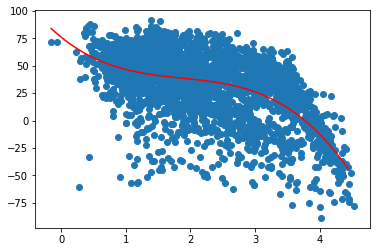

In [23]:
######
# your code here
######

#do the predictions and plot them

x_dummy2 = np.arange(np.min(train['log_minority']),np.max(train['log_minority']),0.1)
yhat_dummy_regress3_5 = regress3_5.predict(PolynomialFeatures(3, include_bias=False).fit_transform(pd.DataFrame(x_dummy2)))

plt.scatter(train['log_minority'],train['votergap'])
plt.plot(x_dummy2,yhat_dummy_regress3_5,c="r",label="Poly(3) Regression")

plt.show()

This plot helps with interpretating the results of the polynomial model (nrealy impossible to interpret the $\beta$ coefficient estimates directly.  This plot shows that the model describes the relationship in the data pretty well: there is a slight negative relationship at most values of log_minority, but it gets much more negative at the highest values of log minority (when minority is above about $e^{3.5}=33$% within a county). 

## Part 4: Variable Selection

In this part we will step through forward variable selection.  Recall our original data set has several quantitative predictors (plus `state`):

['population','hispanic', 'minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'density', 
             'cancer']

Note: several of them are extremely right-skewed and could be better incorporated using the log: population, hispanic, minority, and density (these are the most etreme right-skewed).

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


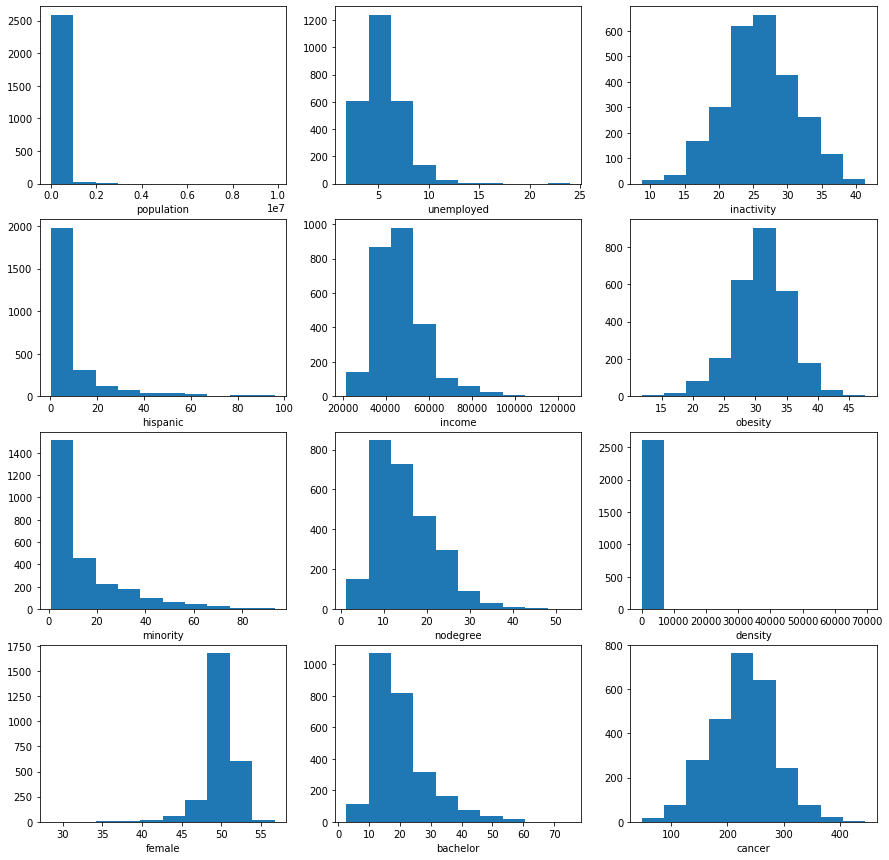

In [24]:
predictors = ['population','hispanic', 'minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'density', 
             'cancer']

fig, ax = plt.subplots(4, 3, figsize=(15, 15))

count = 0
for variable in predictors:
    ax[count%4][int(count/4)].hist(train[variable],)
    ax[count%4][int(count/4)].set_xlabel(variable)
    count = count + 1




In [25]:
train['log_population'] = np.log(train['population'])
train['log_hispanic'] = np.log(train['hispanic'])

test['log_population'] = np.log(test['population'])
test['log_hispanic'] = np.log(test['hispanic'])

# imputing median cancer rate for the 40 or so counties with missing cancer rates
train['cancer'].loc[train['cancer'].isnull()] = np.median(train['cancer'])
test['cancer'].loc[test['cancer'].isnull()] = np.median(train['cancer'])

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Q4.1** Fit the full *main effects* model with the 12 predictor variables listed below.  Determine its $R^2$ in the test set.

In [26]:
predictors = ['log_population','log_hispanic', 'log_minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'log_density']



######
# your code here
######

regress4_1 = LinearRegression(fit_intercept=True).fit(train[predictors], train['votergap'])

r2_test4_1 = sk.metrics.r2_score(test['votergap'], regress4_1.predict(test[predictors]))
print("R-squared on the test set for the main effects model:", r2_test4_1)

R-squared on the test set for the main effects model: 0.5752558339850569


**Q4.2** Fit the full *interaction* model with the 12 predictor variables and all of their interaction terms.  How many interaction terms are involved? Determine its $R^2$ in the test set.

In [27]:
######
# your code here
######
X4_2 = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(train[predictors])
print("There are", X4_2.shape[1]-train[predictors].shape[1]-1,"interaction terms in the design matrix for this model.")

regress4_2 = LinearRegression(fit_intercept=False).fit(X4_2, train['votergap'])

r2_test4_2 = sk.metrics.r2_score(test['votergap'], regress4_2.predict(
    PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])))
print("R-squared on the test set for the full interaction model:", r2_test4_2)

There are 66 interaction terms in the design matrix for this model.
R-squared on the test set for the full interaction model: 0.7121772296069138


Note: the # of interaction terms is correct: ${12 \choose 2} = \frac{12\cdot 11}{2}=66$

Unfortunately there is no automatic way to do sequential variable selection in sklearn or statsmodels (we'll learn why eventually). One way to do manual variable selection is to fit the most complex model you want to consider, and start removing variables one at a time based on their p-value of their $t$-statistic, until all you are left with only statistically significant predictors (with p-values all less than 0.05) model.

The code below shows a brief outline of how to get started with this process in statsmodels:

In [28]:

# First turn the full design matrix into a panda's DataFrame
df4_3 = pd.DataFrame(X4_2)
# print(df4_3.shape)

# Fit the model with all predictors and determine which has the largest p-value
model4_3_temp = lm.OLS(train['votergap'],df4_3).fit()
print(np.argmax(model4_3_temp.pvalues))

# you can confirm it with the summary output
model4_3_temp.summary()

65


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               votergap   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     98.87
Date:                Wed, 01 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:06:55   Log-Likelihood:                -10891.
No. Observations:                2620   AIC:                         2.194e+04
Df Residuals:                    2542   BIC:                         2.239e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0           -384.3901    127.907     -3.005      0.003    -635.203    -133.577
1              5.8408      8.925      0.654      0.513     -11.661      23.342
2             58.0960     10.812      5.373      0.000      36.894      79.298
3             45.7312     12.763      3.583      0.000      20.704      70.758
4              7.8366      3.360      2.332      0.020       1.247      14.426
5             -0.7211      5.306     -0.136      0.892     -11.125       9.683
6              0.0009      0.001      0.738      0.460      -0.001       0.003
7             -1.5510      1.917     -0.809      0.419      -5.310       2.209
8             -1.5254      1.643     -0.929      0.353      -4.746       1.696
9              6.1169      3.001      2.038      0.042       0.232      12.001
10             3.5914      3.177      1.130      0.258      -2.638       9.821
11             4.7921      5.830      0.822      0.411      -6.639      16.224
12            -0.5691      0.185     -3.079      0.002      -0.931      -0.207
13            -1.1371      0.382     -2.979      0.003      -1.886      -0.389
14             2.3378      0.474      4.932      0.000       1.408       3.267
15            -0.2989      0.187     -1.594      0.111      -0.666       0.069
16             0.8023      0.217      3.702      0.000       0.377       1.227
17          8.258e-05   3.53e-05      2.337      0.020    1.33e-05       0.000
18             0.2685      0.069      3.902      0.000       0.134       0.403
19             0.1140      0.058      1.974      0.048       0.001       0.227
20            -0.0430      0.102     -0.421      0.674      -0.244       0.157
21            -0.0687      0.106     -0.645      0.519      -0.277       0.140
22             0.3513      0.178      1.971      0.049       0.002       0.701
23            -4.1921      0.446     -9.397      0.000      -5.067      -3.317
24             2.9638      0.566      5.240      0.000       1.855       4.073
25            -0.4411      0.188     -2.347      0.019      -0.810      -0.073
26            -2.0386      0.245     -8.309      0.000      -2.520      -1.557
27            -0.0001   5.62e-05     -1.922      0.055      -0.000     2.2e-06
28             0.0347      0.090      0.384      0.701      -0.142       0.212
29             0.2786      0.096      2.904      0.004       0.090       0.467
30            -0.0105      0.143     -0.073      0.942      -0.291       0.270
31            -0.2012      0.149     -1.348      0.178      -0.494       0.091
32            -0.0597      0.291     -0.205      0.838      -0.630       0.511
33            -9.2102      0.520    -17.712      0.000     -10.230      -8.190
34            -0.3730      0.236     -1.581      0.114      -0.836       0.090
35            -0.2328      0.261     -0.892      0.373      -0.745       0.279
36

In [29]:
# Now start dropping variables, one at a time
df4_3 = df4_3.drop(np.argmax(model4_3_temp.pvalues),axis=1)
df4_3.shape

(2620, 77)

In [30]:
# And refit, and redetermine the max p=value
model4_3_temp = lm.OLS(train['votergap'],df4_3).fit()
print("Predictor#: ", np.argmax(model4_3_temp.pvalues), ", with associated p-value of" ,np.max(model4_3_temp.pvalues))

Predictor#:  59 , with associated p-value of 0.9305643717295858


**Q4.3** 
Wrap the above code in a function or loop in order to find a strong predictive model.  Determine the $R^2$ in the test set for this parsimonious model.  How does it compare to the predictive ability of the models in Q4.2 and Q4.1?

In [31]:
######
# your code here
######

df4_3 = pd.DataFrame(X4_2)
cutoff = 0.20

for i in np.arange(df4_3.shape[1]):
    model4_3_temp = lm.OLS(train['votergap'],df4_3).fit()
    if(np.max(model4_3_temp.pvalues) > cutoff):
        print("Predictor#:", np.argmax(model4_3_temp.pvalues), "with associated p-value of" ,np.max(model4_3_temp.pvalues))
        df4_3 = df4_3.drop(df4_3.columns[np.argmax(model4_3_temp.pvalues)],axis=1)
    else:
        break

regress4_3 = LinearRegression(fit_intercept=False).fit(df4_3, train['votergap'])
df4_3.shape

Predictor#: 65 with associated p-value of 0.9809439044018047
Predictor#: 59 with associated p-value of 0.9305643717295858
Predictor#: 30 with associated p-value of 0.9249852513988832
Predictor#: 46 with associated p-value of 0.9084284356381296
Predictor#: 73 with associated p-value of 0.904567392409066
Predictor#: 5 with associated p-value of 0.8819331854474379
Predictor#: 66 with associated p-value of 0.8358331725654966
Predictor#: 67 with associated p-value of 0.8368796332970155
Predictor#: 30 with associated p-value of 0.7874028696899534
Predictor#: 56 with associated p-value of 0.7419892871253285
Predictor#: 27 with associated p-value of 0.6873645504482577
Predictor#: 51 with associated p-value of 0.7072222207250043
Predictor#: 19 with associated p-value of 0.6831101803566574
Predictor#: 1 with associated p-value of 0.4927574564274103
Predictor#: 36 with associated p-value of 0.5778097134311744
Predictor#: 56 with associated p-value of 0.4142757137247888
Predictor#: 61 with associa

(2620, 53)

In [32]:
X4_2_test = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])
X4_3_test = pd.DataFrame(X4_2_test)[df4_3.columns]

r2_test4_3 = sk.metrics.r2_score(test['votergap'], regress4_3.predict(X4_3_test))
print("R-squared on the test set for the full interaction model:", r2_test4_3)

R-squared on the test set for the full interaction model: 0.7102472021341706


Even though we have a nice parsimonious model here, we have actually lost a little bit of explanatory power on the test set: the full interaction model had a test $R^2$ of 0.712 while it is 0.705 here.  This is likely due to trimming off some important predictors towards the end of the process even though their p-values were greater than 0.05.  Using a higher cut-off (possibly of 0.10) may be a better choice for out-of-sample prediction here, or use a different metric (like AIC) for choosing which variable to drop and when to stop.